In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras

# If you see "type 'InterpreterWrapper' is already registered!", restart the Jupyter kernel and run all cells again.


In [2]:
##Get the returns of a stock


def get_stock_returns(ticker: str, period: str) -> pd.Series:

    data = yf.download(ticker, period=period, progress=False, auto_adjust=True)

    if data.empty or "Close" not in data.columns:
        raise ValueError(f"No price data returned for {ticker} with the given range.")
    
    close = data["Close"].astype(float)
    returns = close.pct_change().dropna()
    returns.name = f"{ticker}_returns"

    return returns

In [3]:
##CAC40 5 years returns
cac40_returns = get_stock_returns("^FCHI", period="1mo")

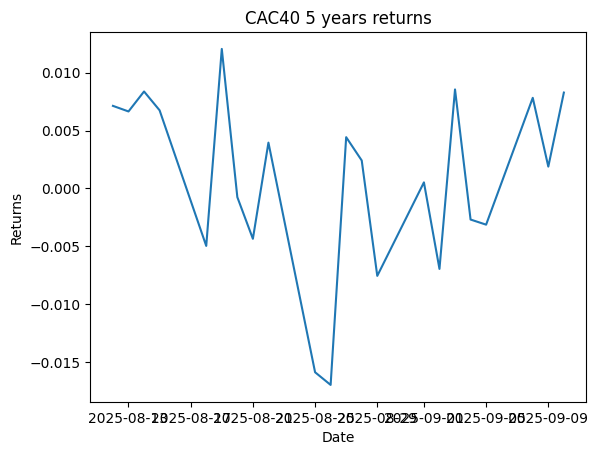

In [4]:
##Plot the returns


plt.plot(cac40_returns)
plt.title("CAC40 5 years returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

In [5]:
def returns_to_prices(returns: pd.DataFrame, start_price: float = 100, log: bool = False):
    if log:
        return np.exp(returns.cumsum()) * start_price
    else:
        return (1 + returns).cumprod() * start_price



In [6]:
CAC40_TICKERS = [
    "AI.PA","AIR.PA","MT.AS","ALO.PA","CS.PA","BNP.PA","EN.PA","CAP.PA","CA.PA",
    "ACA.PA","BN.PA","DSY.PA","ENGI.PA","EL.PA","RMS.PA","KER.PA","OR.PA",
    "LR.PA","MC.PA","ML.PA","ORA.PA","RI.PA","PUB.PA","RNO.PA","SAF.PA","SGO.PA",
    "SAN.PA","SU.PA","GLE.PA","TEP.PA","HO.PA","TTE.PA",
    "VIE.PA","DG.PA","VIV.PA","WLN.PA","MNDI.L"   
]

TICKER_TO_NAME = {
    "AI.PA": "Air Liquide",
    "AIR.PA": "Airbus",
    "ALO.PA": "Alstom",
    "MT.AS": "ArcelorMittal",
    "CS.PA": "AXA",
    "BNP.PA": "BNP Paribas",
    "EN.PA": "Bouygues",
    "CAP.PA": "Capgemini",
    "CA.PA": "Carrefour",
    "ACA.PA": "Crédit Agricole",
    "BN.PA": "Danone",
    "DSY.PA": "Dassault Systèmes",
    "ENGI.PA": "Engie",
    "EL.PA": "EssilorLuxottica",
    "RMS.PA": "Hermès",
    "KER.PA": "Kering",
    "LR.PA": "Legrand",
    "OR.PA": "L’Oréal",
    "MC.PA": "LVMH",
    "ML.PA": "Michelin",
    "ORA.PA": "Orange",
    "RI.PA": "Pernod Ricard",
    "PUB.PA": "Publicis Groupe",
    "RNO.PA": "Renault",
    "SAF.PA": "Safran",
    "SGO.PA": "Saint-Gobain",
    "SAN.PA": "Sanofi",
    "SU.PA": "Schneider Electric",
    "GLE.PA": "Société Générale",
    "STLA.MI": "Stellantis",
    "STM.PA": "STMicroelectronics",
    "TEP.PA": "Teleperformance",
    "HO.PA": "Thales",
    "TTE.PA": "TotalEnergies",
    "URW.AS": "Unibail-Rodamco-Westfield",
    "VIE.PA": "Veolia",
    "DG.PA": "Vinci",
    "VIV.PA": "Vivendi",
    "WLN.PA": "Worldline",
    "^FCHI": "CAC 40"
}

NAME_TO_TICKER = {name: ticker for ticker, name in TICKER_TO_NAME.items()}


In [7]:
# Get returns for all CAC40 stocks
returns_list = []
for ticker in CAC40_TICKERS:

    returns = get_stock_returns(ticker, period="1mo")
    if returns is not None:
        returns_list.append(returns)
returns_list.append(cac40_returns)
returns_list=pd.concat(returns_list, axis=1).dropna()

In [8]:
##Correlation matrix of multiple assets

def plot_corr_heatmap_with_names(returns):
    corr = returns.corr()

    # Replace tickers with company names
    corr = corr.rename(index=TICKER_TO_NAME, columns=TICKER_TO_NAME)

    plt.figure(figsize=(16, 14))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0,
                xticklabels=corr.columns, yticklabels=corr.index)
    plt.title("CAC 40 Stocks Correlation (Company Names)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return corr

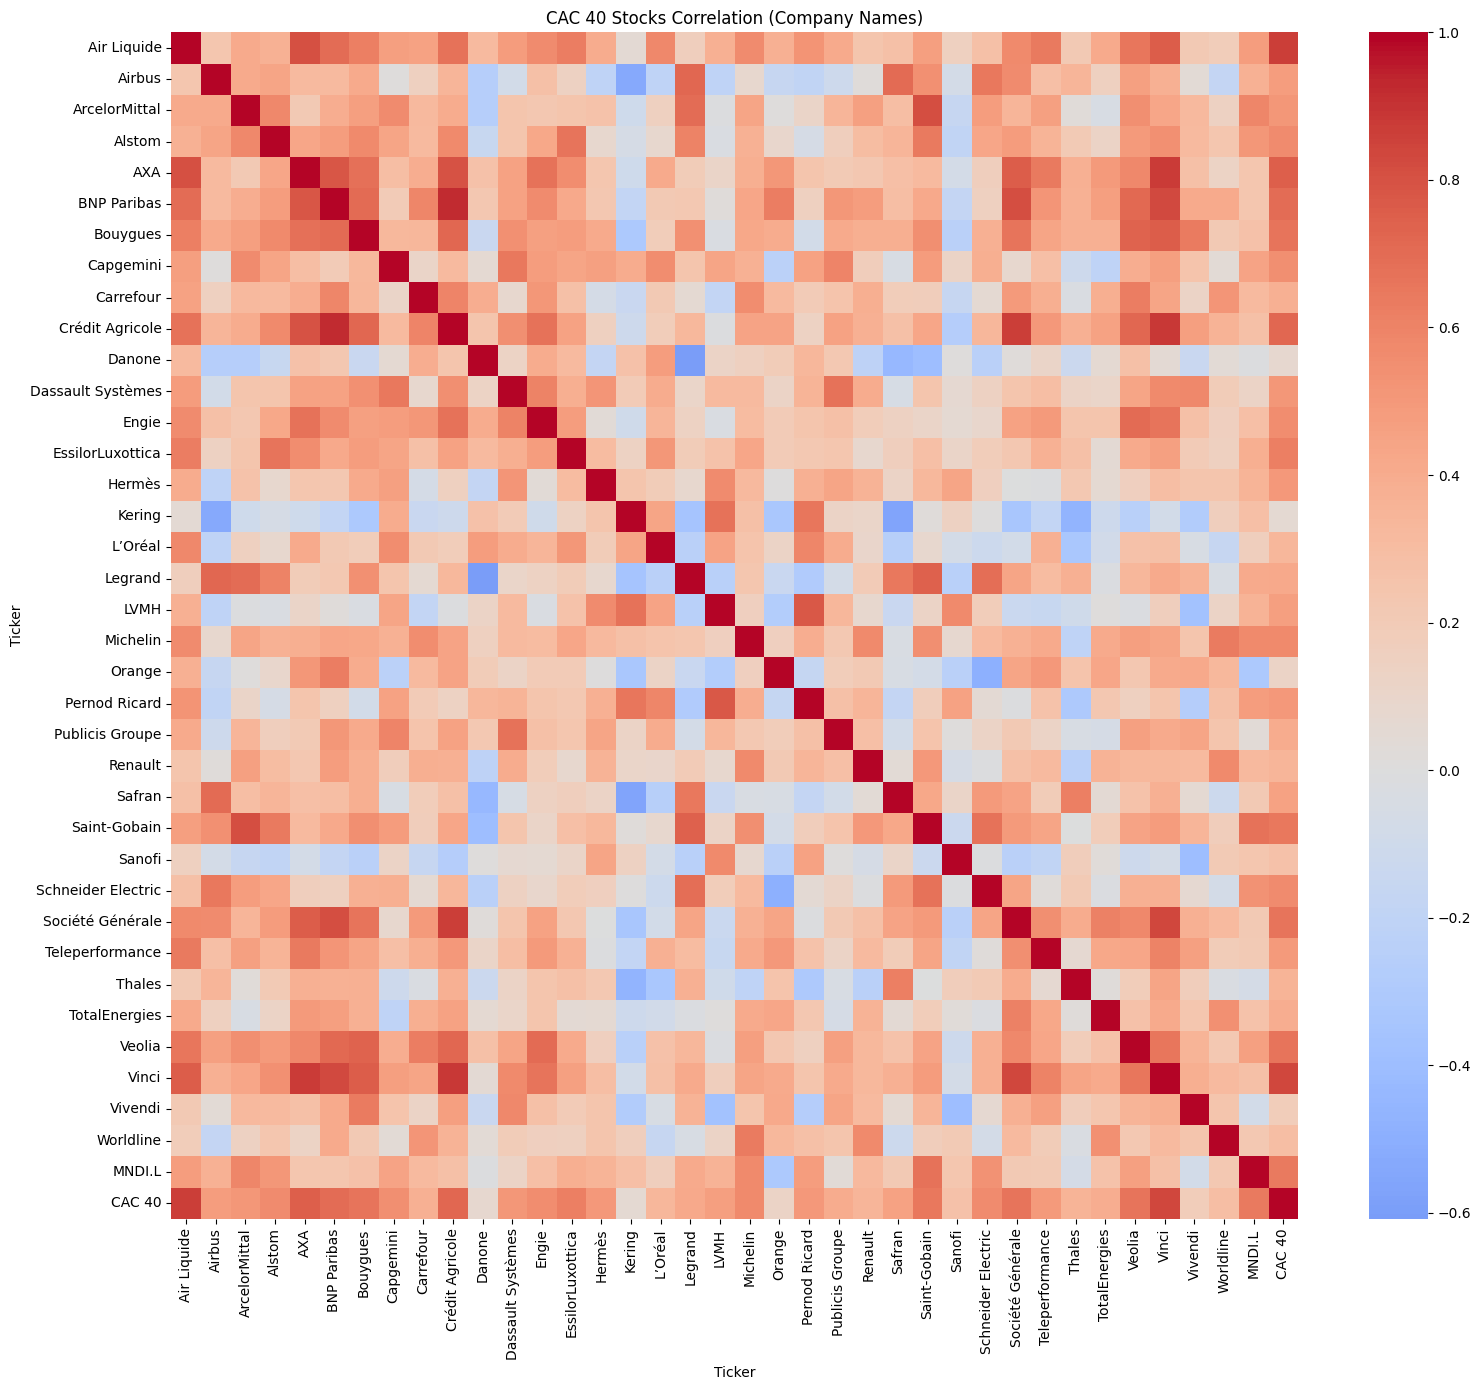

Ticker              Air Liquide  Airbus  ArcelorMittal  Alstom   AXA  \
Ticker                                                                 
Air Liquide                1.00    0.24           0.41    0.37  0.81   
Airbus                     0.24    1.00           0.41    0.44  0.32   
ArcelorMittal              0.41    0.41           1.00    0.58  0.21   
Alstom                     0.37    0.44           0.58    1.00  0.43   
AXA                        0.81    0.32           0.21    0.43  1.00   
BNP Paribas                0.69    0.31           0.40    0.48  0.78   
Bouygues                   0.62    0.41           0.47    0.57  0.68   
Capgemini                  0.47    0.01           0.56    0.44  0.30   
Carrefour                  0.45    0.15           0.32    0.31  0.40   
Crédit Agricole            0.67    0.34           0.40    0.57  0.79   
Danone                     0.32   -0.26          -0.26   -0.16  0.27   
Dassault Systèmes          0.49   -0.08           0.24    0.25  

In [9]:
# === Example usage ===
corr_matrix = plot_corr_heatmap_with_names(returns_list)

# If you want to see it as a clean DataFrame table:
print(corr_matrix.round(2))


In [10]:
def get_least_correlated(corr_matrix, n=5):
    # Work with absolute values
    abs_corr = corr_matrix.abs()
    # Drop self-correlation (diagonal = 1)
    avg_corr = abs_corr.mean(axis=1) - 1/len(abs_corr)
    # Sort ascending (lowest avg correlation = most decorrelated)
    return avg_corr.sort_values().head(n)

In [11]:
least_corr=get_least_correlated(corr_matrix, n=5)
print("5 most decorrelated stocks:")
print(get_least_correlated(corr_matrix, n=5))


5 most decorrelated stocks:
Ticker
Sanofi       0.166746
Danone       0.209529
Thales       0.223204
LVMH         0.227297
Worldline    0.229388
dtype: float64


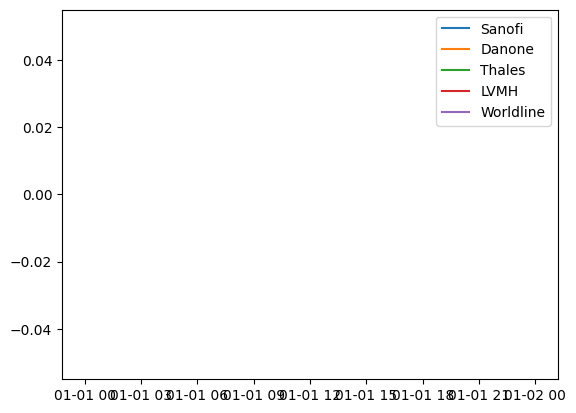

In [12]:
for name in least_corr.index:
    plt.plot(returns_list[NAME_TO_TICKER[name]].loc['2025-01-01':'2025-02-01'], label=name)
plt.legend()
plt.show()

In [13]:
NASDAQ_TICKERS = [
    "AAPL","MSFT","GOOGL","AMZN","TSLA","NVDA","META","PYPL","ADBE","NFLX",
    "INTC","CSCO","CMCSA","PEP","AVGO","TMUS","TXN","QCOM","AMD",
    "SBUX","BKNG","ISRG","GILD","MDLZ","ADP","LRCX","MU","ZM",
    "MAR","ILMN","REGN","CTAS","EA","ADSK","LULU","BIIB","SNPS",
    "EXC","WBA","VRSK","DLTR","IDXX","ALGN","MELI","ROST","KHC","ORLY",
    "PCAR","FAST","SIRI","CDNS","XEL","CTSH","BIDU","LBTYA","JD","NTES","KLAC","WDC","VRSN",
    "MCHP","ANSS","ASML","MRVL","SWKS","V","MA","PYPL","FIS",
    "ADP","INTU","PAYC","NOW","CRM","TEAM","DOCU","CRWD","OKTA","NET","DDOG","SNOW","PLTR","FVRR"
]
NAME_TO_TICKER_NASDAQ = {
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "Alphabet": "GOOGL",
    "Amazon": "AMZN",
    "Tesla": "TSLA",
    "NVIDIA": "NVDA",
    "Meta Platforms": "META",
    "PayPal": "PYPL",
    "Adobe": "ADBE",
    "Netflix": "NFLX",
    "Intel": "INTC",
    "Cisco Systems": "CSCO",
    "Comcast": "CMCSA",
    "PepsiCo": "PEP",
    "Broadcom": "AVGO",
    "Costco Wholesale": "COST",
    "T-Mobile US": "TMUS",
    "Texas Instruments": "TXN",
    "Qualcomm": "QCOM",
    "Advanced Micro Devices": "AMD",
    "Starbucks": "SBUX",
    "Booking Holdings": "BKNG",
    "Intuitive Surgical": "ISRG",
    "Gilead Sciences": "GILD",
    "Mondelez International": "MDLZ",
    "Fiserv": "FISV",
    "Automatic Data Processing": "ADP",
    "Lam Research": "LRCX",
    "Micron Technology": "MU",
    "Zoom Video Communications": "ZM",
    "Activision Blizzard": "ATVI",
    "Marriott International": "MAR",
    "Illumina": "ILMN",
    "Regeneron Pharmaceuticals": "REGN",
    "Cintas": "CTAS",
    "Electronic Arts": "EA",
    "Autodesk": "ADSK",
    "Lululemon Athletica": "LULU",
    "Biogen": "BIIB",
    "Synopsys": "SNPS",
    "Exelon": "EXC",
    "Walgreens Boots Alliance": "WBA",
    "Verisk Analytics": "VRSK",
    "Dollar Tree": "DLTR",
    "IDEXX Laboratories": "IDXX",
    "Align Technology": "ALGN",
    "MercadoLibre": "MELI",
    "Ross Stores": "ROST",
    "Kraft Heinz": "KHC",
    "O'Reilly Automotive": "ORLY",
    "PACCAR": "PCAR",
    "Fastenal": "FAST",
    "Sirius XM Holdings": "SIRI",
    "Cadence Design Systems": "CDNS",
    "Xcel Energy": "XEL",
    "Cognizant Technology Solutions": "CTSH",
    "Baidu": "BIDU",
    "Liberty Global": "LBTYA",
    "JD.com": "JD",
    "NetEase": "NTES",
    "KLA Corporation": "KLAC",
    "Western Digital": "WDC",
    "Verisign": "VRSN",
    "Microchip Technology": "MCHP",
    "ANSYS": "ANSS",
    "ASML Holding": "ASML",
    "Marvell Technology": "MRVL",
    "Xilinx": "XLNX",
    "Skyworks Solutions": "SWKS",
    "Citrix Systems": "CTXS",
    "Visa": "V",
    "Mastercard": "MA",
    "Square": "SQ",
    "Fis": "FIS",
    "Intuit": "INTU",
    "Paycom Software": "PAYC",
    "ServiceNow": "NOW",
    "Salesforce": "CRM",
    "Slack Technologies": "WORK",
    "Atlassian": "TEAM",
    "Zendesk": "ZEN",
    "DocuSign": "DOCU",
    "CrowdStrike": "CRWD",
    "Okta": "OKTA",
    "Cloudflare": "NET",
    "Datadog": "DDOG",
    "Snowflake": "SNOW",
    "Palantir Technologies": "PLTR",
    "Fiverr International": "FVRR"
}

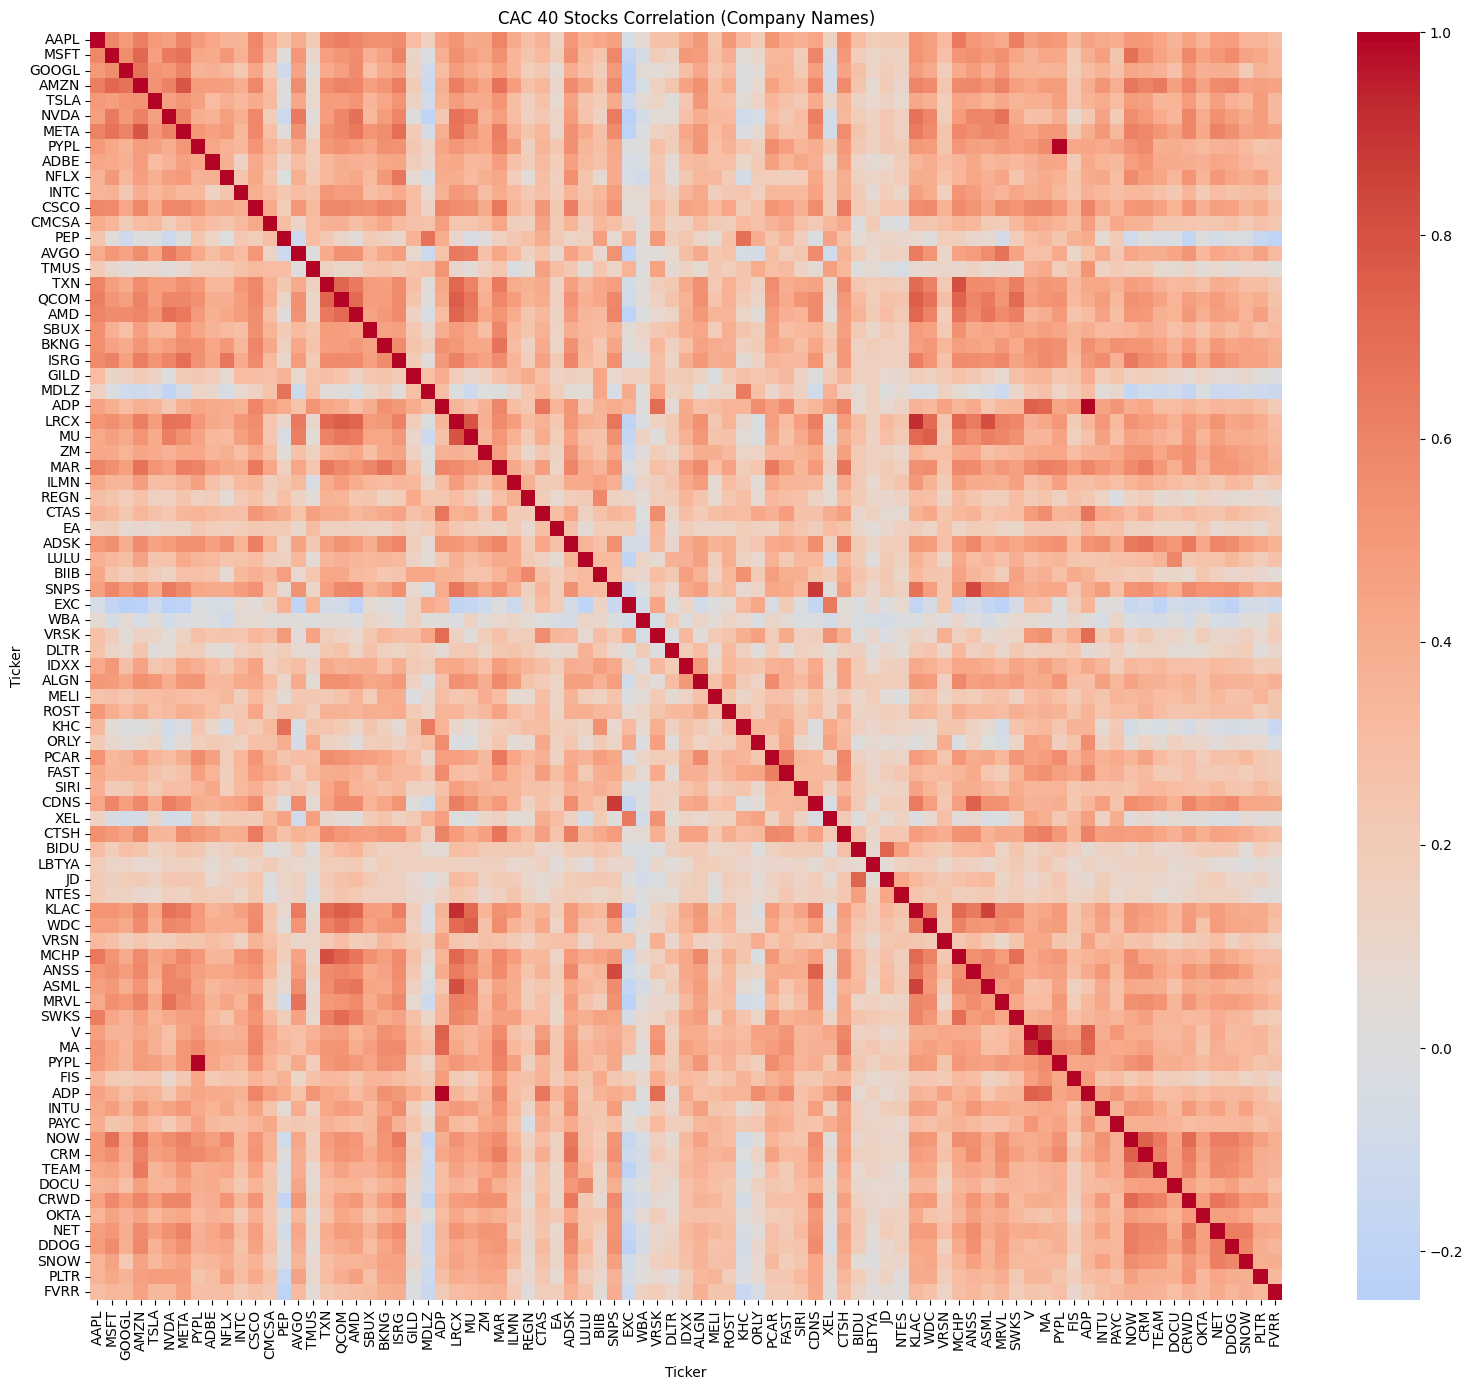

In [14]:
#Plot the correlation heatmap for NASDAQ stocks
corr_matrix_nasdaq = plot_corr_heatmap_with_names(
    pd.concat([get_stock_returns(ticker, period="1y") for ticker in NASDAQ_TICKERS if get_stock_returns(ticker, period="1y") is not None], axis=1).dropna()
)

In [15]:
#NN giving a grade for a value between 0 and 1 based on fundamental analysis and indicators

##Get all the indicators( like PE ratio, EPS, ROE, country, sector, date, etc) for a given stock and store them in a dataframe
## Build a NN model to predict a score between 0 and 1 based on these indicators
## Based on the grade, invest on stocks with a grade above a certain threshold
## Compare with the buy and hold strategy over a certain period
## Adjust NN
## Backtest


In [ ]:
def _pick_row(df: pd.DataFrame, candidates):
    for k in candidates:
        if k in df.index:
            return df.loc[k]
    return None

def get_historical_pe(ticker, start="2020-01-01", end=None):
    t = yf.Ticker(ticker)

    # 1) Daily price
    prices = t.history(start=start, end=end, auto_adjust=False)["Close"]
    if prices.empty:
        raise ValueError("No price data.")

    # 2) Quarterly financials
    inc = t.get_income_stmt(freq="quarterly")  # rows x columns (dates)
    if inc is None or inc.empty:
        raise ValueError("No income statement data.")

    # Try to find Net Income (common)
    net_income = _pick_row(inc, [
        "Net Income",
        "Net Income Common Stockholders",
        "Net Income Applicable To Common Shares",
        "Net Income Including Noncontrolling Interests"
    ])
    if net_income is None:
        raise ValueError("Couldn't find a Net Income row.")

    # Try to find diluted average shares; fallback to basic
    diluted_shares = _pick_row(inc, [
        "Diluted Average Shares",
        "Diluted Shares Outstanding",
        "Diluted EPS Total Shares",
        "Diluted Weighted Average Shares"
    ])
    if diluted_shares is None:
        diluted_shares = _pick_row(inc, [
            "Basic Average Shares",
            "Basic Shares Outstanding",
            "Basic Weighted Average Shares"
        ])

    # If shares not found in the income stmt, try full share history (daily)
    if diluted_shares is None:
        try:
            shares_full = t.get_shares_full(start=start)
            # align to quarter ends by taking last value before/at the quarter date
            diluted_shares = shares_full.reindex(inc.columns, method="ffill")
        except Exception:
            diluted_shares = None

    if diluted_shares is None or diluted_shares.isna().all():
        raise ValueError("Couldn't find any (diluted/basic) average shares series.")

    # 3) Build TTM EPS from last 4 quarters: EPS_TTM ≈ sum(NetIncome_q) / mean(Shares_q)
    # (Both series are quarterly indexed by period-end date)
    net_income = net_income.sort_index()
    diluted_shares = diluted_shares.sort_index()

    # Align the two (intersection of quarter dates)
    qidx = net_income.index.intersection(diluted_shares.index)
    ni_q = net_income.reindex(qidx)
    sh_q = diluted_shares.reindex(qidx)

    # rolling 4-quarter sums/means
    ni_ttm = ni_q.rolling(4).sum()
    sh_ttm = sh_q.rolling(4).mean()

    eps_ttm = (ni_ttm / sh_ttm).dropna()
    if eps_ttm.empty:
        raise ValueError("Not enough quarters to compute TTM EPS (need ≥ 4).")

    # 4) Convert quarterly EPS_TTM to daily by forward-filling between report dates
    eps_ttm_daily = eps_ttm.reindex(prices.index, method="ffill")

    # 5) Daily PE = Price / EPS_TTM
    pe = (prices / eps_ttm_daily).dropna()
    pe.name = f"{ticker}_PE"
    return pe

# Example:
# pe_series = get_historical_pe("AAPL", start="2020-01-01", end="2023-01-01")
# print(pe_series.head())


KeyError: 'Diluted EPS'